In [16]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import random
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
#model = AutoModel.from_pretrained( "gpt2", output_hidden_states=True)  #load pretrained from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token

model.eval()    # Set to evaluation mode: Turns off dropout, ensuring deterministic outputs; Freezes running statistics (in LayerNorm).

c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [18]:
prompts = {
    "short": [
        "Sunset",
        "The quick fox",
        "Hello world",
        "Once upon a",
        "Artificial intelligence"
    ],
    "medium": [
        "The cat sat on the warm windowsill and purred quietly.",
        "He opened the door to find a mysterious package waiting.",
        "Deep learning has revolutionized computer vision and natural language processing.",
        "A sudden noise startled her while she was reading a book.",
        "The recipe called for eggs, flour, sugar, and a pinch of salt."
    ],
    "long": [
        "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives.",
        "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away.",
        "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."
    ],
    "very_long": [
        "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again.",
        "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."
    ],
    "closed": [
    "Water freezes at 0 degrees",
    "The author of Romeo and Juliet is", 
    "Einstein is best known for the theory of",
    "Brazil's official language is",
    "Jupiter is the largest",
    "Gold’s chemical symbol is",
    "Opposite in meaning to 'hot' is",
    "Where is the Great Wall located?",
    "Tokyo is the capital of",
    "A triangle has how many sides?",
    "The boiling point of water in Celsius is",
    "Who painted the Mona Lisa?",
    "Pi is approximately equal to",
    "Mount Everest is located in which country?"
    ]
}

target_answers = {
    "Water freezes at 0 degrees": "Celsius",
    "The author of Romeo and Juliet is": "Shakespeare",
    "Einstein is best known for the theory of": "relativity",
    "Brazil's official language is": "Portuguese",
    "Jupiter is the largest": "planet",
    "Gold’s chemical symbol is": "Au",
    "Opposite in meaning to 'hot' is": "cold",
    "Where is the Great Wall located?": "China",
    "Tokyo is the capital of": "Japan",
    "A triangle has how many sides?": "3",
    "The boiling point of water in Celsius is": "100",
    "Who painted the Mona Lisa?": "Leonardo",
    "Pi is approximately equal to": "3.14",
    "Mount Everest is located in which country?": "Nepal"
}

# TO USE:
# for category, prompt_list in prompts.items():
#    for prompt in prompt_list:
#        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
#        outputs = model(**inputs)
#        # your embedding analysis here...


## Testing the prediction on next token

With a set of closed prompts each designed to have a specific, factual answer

In [19]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [20]:
prompt = prompts["closed"][2]
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Tokens:")
for idx, tok in enumerate(tokens):
    print(f"{idx:2}: {tok}")

# Containers for layer outputs
embedding_outputs = []
attention_outputs = []
mlp_outputs = []
ln1_outputs = []
ln2_outputs = []

# Hook functions to capture intermediate activations
def get_embedding_output(module, input, output):
    embedding_outputs.append(output.detach())

def get_attention_output(module, input, output):
    attention_outputs.append(output[0].detach())

def get_mlp_output(module, input, output):
    mlp_outputs.append(output.detach())

def get_ln1_output(module, input, output):
    ln1_outputs.append(output.detach())

def get_ln2_output(module, input, output):
    ln2_outputs.append(output.detach())


# Register forward hooks
model.transformer.drop.register_forward_hook(get_embedding_output)
#model.transformer.wpe.register_forward_hook(get_embedding_output)

for block in model.transformer.h:
    block.ln_1.register_forward_hook(get_ln1_output)
    block.attn.register_forward_hook(get_attention_output)
    block.ln_2.register_forward_hook(get_ln2_output)
    block.mlp.register_forward_hook(get_mlp_output)

model.transformer.ln_f.register_forward_hook(get_ln1_output)

Tokens:
 0: E
 1: instein
 2: Ġis
 3: Ġbest
 4: Ġknown
 5: Ġfor
 6: Ġthe
 7: Ġtheory
 8: Ġof


In [21]:
# Clear stored outputs before a new forward pass
embedding_outputs.clear()
attention_outputs.clear()
mlp_outputs.clear()
ln1_outputs.clear()
ln2_outputs.clear()

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # Shape: [1, seq_len, vocab_size]
attentions = outputs.attentions  # List of [1, n_heads, seq_len, seq_len]


## See most probable next token, entropy and attention at each layer

Prompt: Einstein is best known for the theory of

[Attention] Layer  0: Last Token Entropy 1.2889, Mean Entropy 2.5539
   1:       Ġthe (0.8244)
   2:         Ġ" (0.1034)
   3:         Ġa (0.0194)
   4:         Ġ' (0.0040)
   5:         ĠD (0.0021)
   6:      Ġmore (0.0021)
   7:         ĠL (0.0016)
   8:     Ġfirst (0.0016)
   9:     Ġother (0.0016)
  10:        Ġan (0.0015)
[Attention] Layer  1: Last Token Entropy 14.4204, Mean Entropy 12.3701
   1:        ©¶æ (0.0037)
   2:  SPONSORED (0.0023)
   3:     sonian (0.0017)
   4:   catentry (0.0016)
   5:     Ġfixme (0.0015)
   6:   Streamer (0.0014)
   7: Ġpractition (0.0012)
   8: ĠFlavoring (0.0012)
   9: natureconservancy (0.0012)
  10:     soType (0.0012)
[Attention] Layer  2: Last Token Entropy 13.7618, Mean Entropy 14.3985
   1:   Ġphysics (0.0078)
   2:  Ġtheories (0.0069)
   3: Ġunfolding (0.0032)
   4: Ġconvergence (0.0031)
   5:   Ġbeliefs (0.0025)
   6:   Ġtheorem (0.0025)
   7:  Ġcalculus (0.0022)
   8: Ġphotography (0.0021)

[Attention] Layer  4: Last Token Entropy 13.7100, Mean Entropy 14.6006
   1:    binding (0.0033)
   2:      music (0.0030)
   3:        jew (0.0027)
   4:     ĠBeaut (0.0024)
   5:       Ġcar (0.0024)
   6:     Ġmusic (0.0022)
   7:      ĠKate (0.0020)
   8:        Ġco (0.0018)
   9:        Bra (0.0018)
  10:         mt (0.0017)
[Attention] Layer  5: Last Token Entropy 14.0233, Mean Entropy 14.8135
   1:    Ġtheory (0.0041)
   2: Ġformation (0.0026)
   3:      negie (0.0022)
   4: Ġhereditary (0.0022)
   5: Ġconstitution (0.0022)
   6:  Ġtheories (0.0020)
   7:   Ġphysics (0.0018)
   8:      Ġneur (0.0017)
   9:       ĠMut (0.0016)
  10: Ġrelativity (0.0014)
[Attention] Layer  6: Last Token Entropy 13.3047, Mean Entropy 14.8446
   1:  Ġtheories (0.0100)
   2:    Ġdoping (0.0069)
   3:   ĠGalileo (0.0042)
   4:      ĠSchr (0.0038)
   5: Ġexperiments (0.0038)
   6:    instein (0.0037)
   7: Ġcorrelations (0.0035)
   8:    Ġtheory (0.0030)
   9:   ĠHawking (0.0030)
  10: Ġcorrelation (0.0

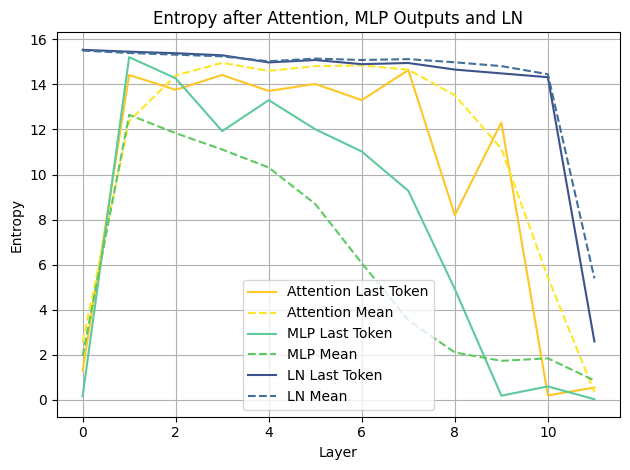

In [22]:
# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 10  # Change as needed
token_position = -1  # Last token in prompt

print(f"Prompt: {prompt}\n")

temperature = 1.0  # Try 0.7 for sharper, or 1.5 for more diverse

def compute_entropy_from_outputs(outputs_list, label):
    entropy_last = []
    entropy_mean = []
    for i, layer_output in enumerate(outputs_list):
        hidden = layer_output  # shape: [1, seq_len, hidden_dim]
        last_token_vec = hidden[0, token_position, :]  # [hidden_dim]
        logits = lm_head(last_token_vec)
        scaled_logits = logits / temperature
        probs = torch.softmax(scaled_logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, top_k)
        top_tokens = tokenizer.convert_ids_to_tokens(top_ids)
        
        entropy = -torch.sum(probs * torch.log2(probs + 1e-12)).item()
        entropy_last.append(entropy)

        all_logits = lm_head(hidden[0])  # shape: [seq_len, vocab_size]
        all_scaled_logits = all_logits / temperature
        all_probs = torch.softmax(all_scaled_logits, dim=-1)
        all_entropy = -torch.sum(all_probs * torch.log2(all_probs + 1e-12)).item()
        mean_entropy = all_entropy / all_probs.size(0)
        entropy_mean.append(mean_entropy)

        print(f"[{label}] Layer {i:2d}: Last Token Entropy {entropy:.4f}, Mean Entropy {mean_entropy:.4f}")
        for j in range(top_k):
            print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")

    
    return entropy_last, entropy_mean

# Compute for attention and MLP outputs
attn_entropy_last, attn_entropy_mean = compute_entropy_from_outputs(attention_outputs, "Attention")
mlp_entropy_last, mlp_entropy_mean = compute_entropy_from_outputs(mlp_outputs, "MLP")
ln_entropy_last, ln_entropy_mean = compute_entropy_from_outputs(ln1_outputs, "LN")

# Plotting
plt.plot(attn_entropy_last, label="Attention Last Token", c= "#fdc725")
plt.plot(attn_entropy_mean,"--", label="Attention Mean", c='#fde725')
plt.plot(mlp_entropy_last, label="MLP Last Token", c="#5ec99b")
plt.plot(mlp_entropy_mean,"--", label="MLP Mean", c='#5ec962')
plt.plot(ln_entropy_last[1:], label="LN Last Token", c='#3b528b')
plt.plot(ln_entropy_mean[1:],"--", label="LN Mean", c="#426f9a")
plt.xlabel("Layer")
plt.ylabel("Entropy")
plt.title("Entropy after Attention, MLP Outputs and LN")
plt.legend(loc='lower center')
plt.grid(True)
plt.tight_layout()
plt.show()


To analyze the dynamics of hidden states across layers, you're essentially exploring how the internal token representations evolve at each layer of the transformer. Here are several ways you can analyze and visualize these dynamics effectively:

1. Cosine Similarity Between Contiguous Layers -> ROTATIONS OF TOKENS DURING TRANSFORMATION

Measure how the hidden representation of a specific token (e.g., the last token "William") changes across layers.
Cosine similarity is a measure of similarity between two vectors based on the angle between them—not their length. It's commonly used in natural language processing (NLP) to compare how "similar" two token embeddings or hidden states are.

Formula:
For two vectors A and B, the cosine similarity is:

cosine_similarity(𝐴,𝐵)=𝐴⋅𝐵/(∥𝐴∥∥𝐵∥)

1.0 → Vectors point in the same direction → Very similar

0.0 → Vectors are orthogonal (90° apart) → No similarity

–1.0 → Vectors point in opposite directions → Completely dissimilar
​

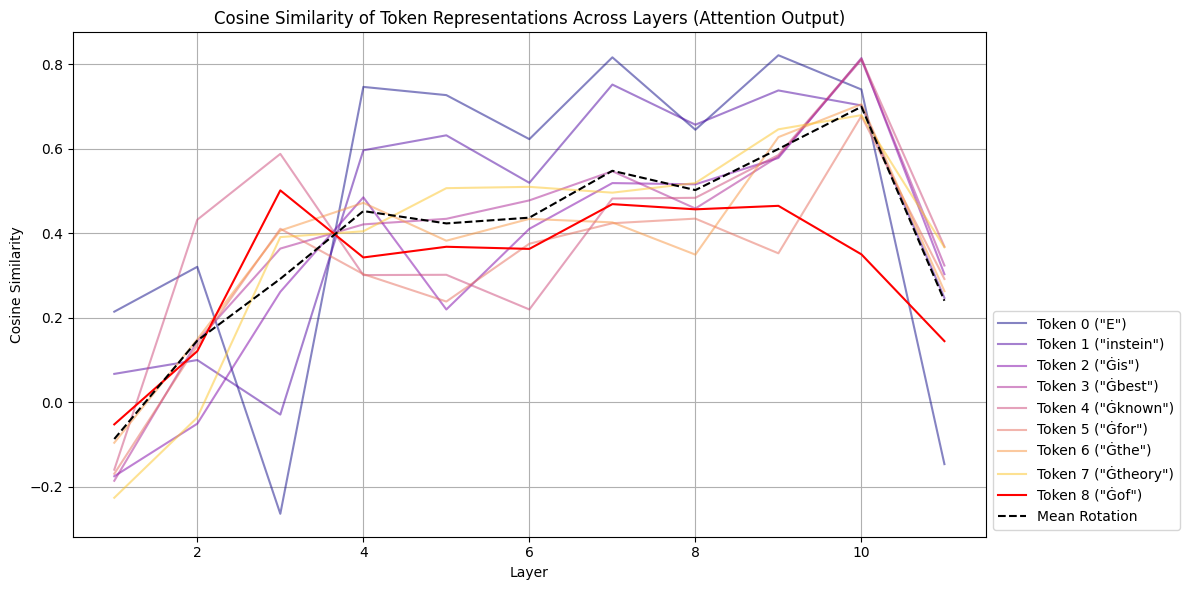

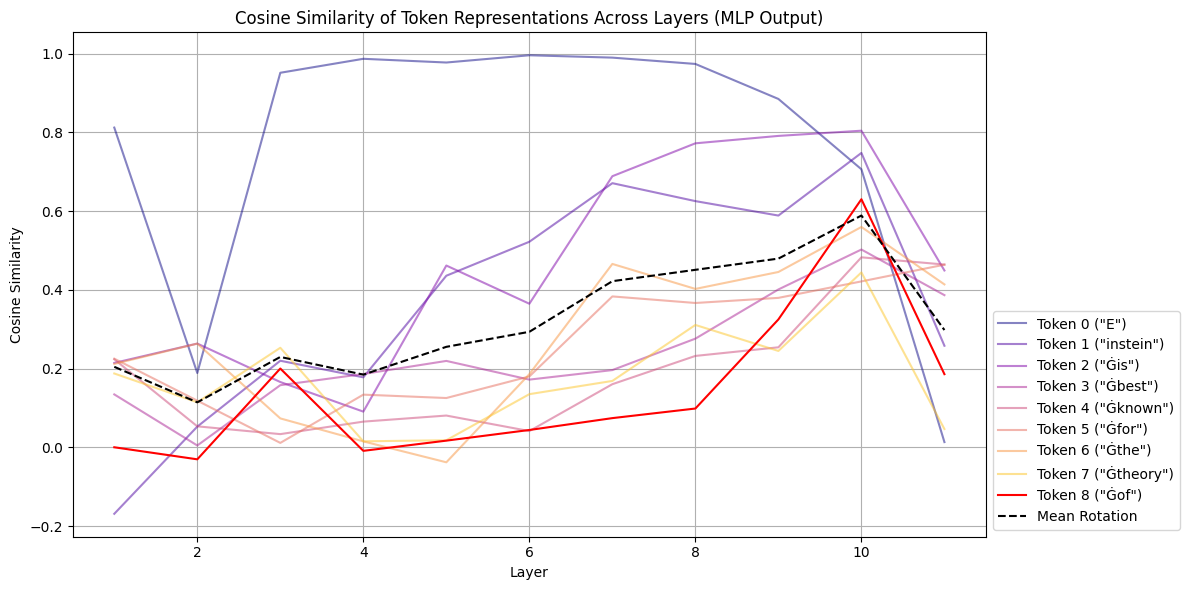

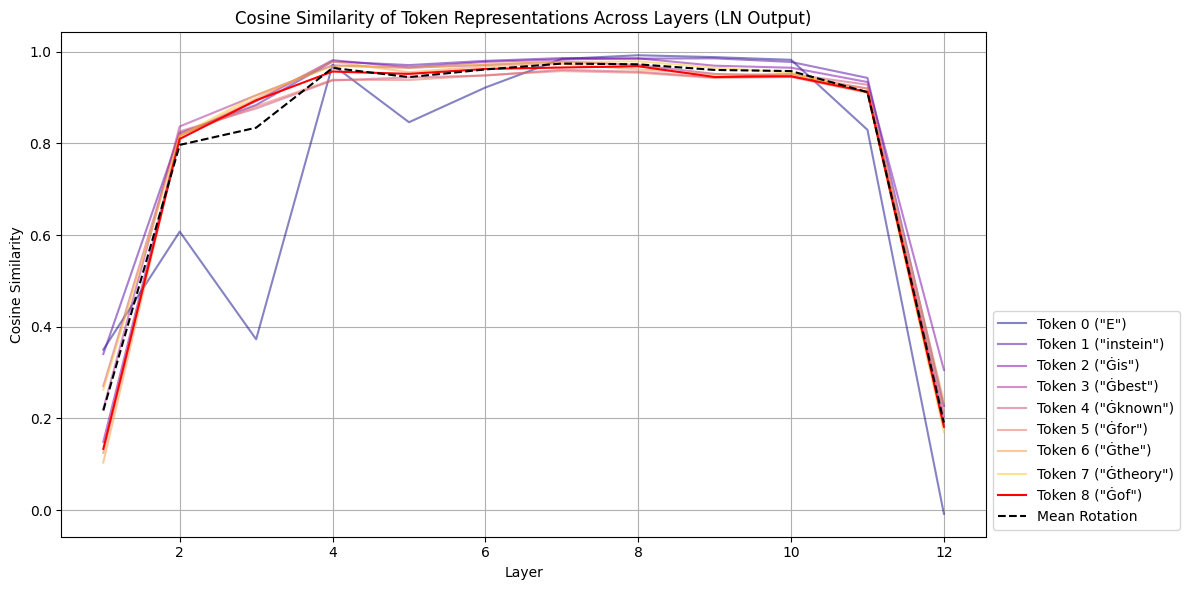

In [23]:
def compute_cosine_rotations(outputs_list, tokens, label):
    seq_len = outputs_list[0].shape[1]  # sequence length
    n_layers = len(outputs_list)
    
    all_token_rotations = []
    for pos in range(seq_len):
        vectors = [outputs_list[i][0, pos].numpy() for i in range(n_layers)]
        cos_sims = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(n_layers - 1)]
        all_token_rotations.append(cos_sims)

    rot_array = np.array(all_token_rotations)  # [seq_len, n_layers - 1]
    mean_rotations = np.mean(rot_array, axis=0)
    colors = cm.plasma(np.linspace(0, 1, seq_len))

    # Plot
    plt.figure(figsize=(12, 6))
    for pos in range(seq_len - 1):
        plt.plot(range(1, n_layers), rot_array[pos], c=colors[pos], label=f'Token {pos} ("{tokens[pos]}")', alpha=0.5)
    plt.plot(range(1, n_layers), rot_array[-1], label=f'Token {seq_len - 1} ("{tokens[-1]}")', color='red')
    plt.plot(range(1, n_layers), mean_rotations,'--', label='Mean Rotation', color='black')

    plt.title(f'Cosine Similarity of Token Representations Across Layers ({label})')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rot_array, mean_rotations

# Attention and MLP outputs are already captured using hooks
attn_rot_array, attn_mean_rot = compute_cosine_rotations(attention_outputs, tokens, "Attention Output")
mlp_rot_array, mlp_mean_rot = compute_cosine_rotations(mlp_outputs, tokens, "MLP Output")
ln_rot_array, ln_mean_rot = compute_cosine_rotations(ln1_outputs, tokens, "LN Output")

1.1. Similarity measures with Target token (for closed prompts)

Interpretation:
Cosine similarity shows directional alignment — higher means more semantically aligned.

Euclidean distance shows absolute position closeness — lower means closer in space.

##### We try with 10 most probable tokens

In [35]:
top_tokens = [
    "Ġrelativity", "Ġgravity", "Ġgeneral", "Ġgravitational", "Ġthe",
    "Ġquantum", "ĠGeneral", "Ġevolution", "ĠEinstein", "Ġgrav"
]

token_ids = tokenizer.convert_tokens_to_ids(top_tokens)
with torch.no_grad():
    top_embeddings = model.transformer.wte(torch.tensor([token_ids])).squeeze().numpy()

C:\Users\angel\AppData\Local\Temp\ipykernel_25076\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


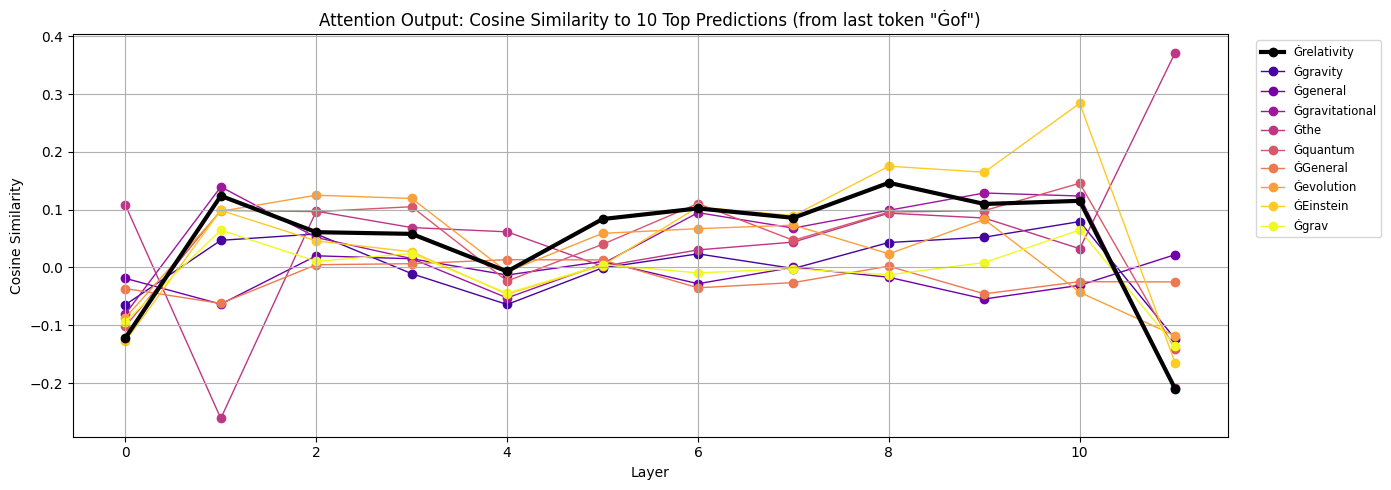

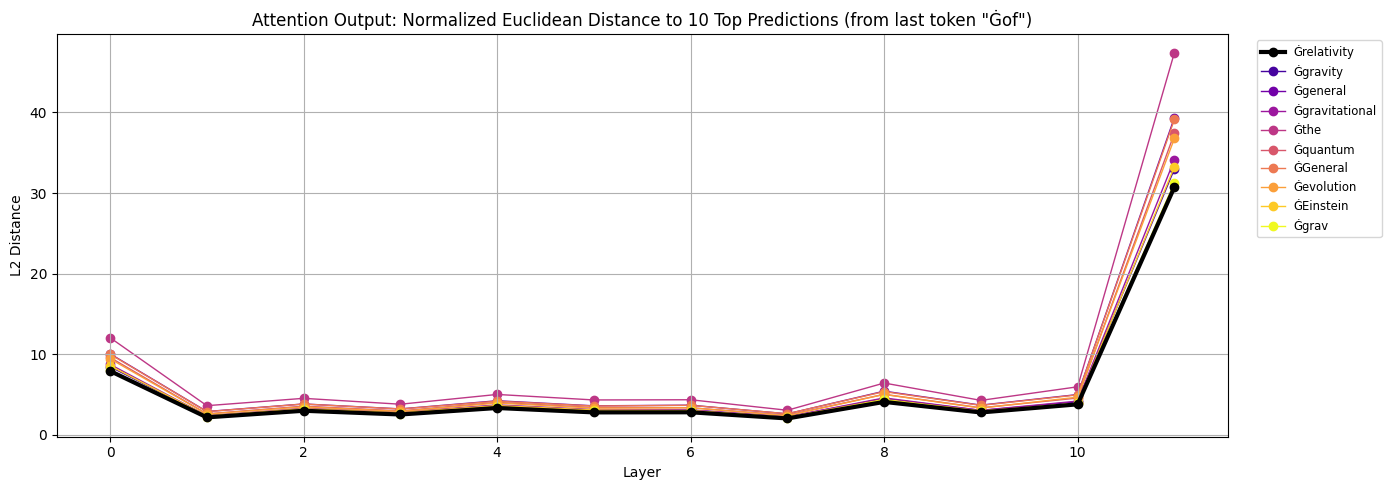

C:\Users\angel\AppData\Local\Temp\ipykernel_25076\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


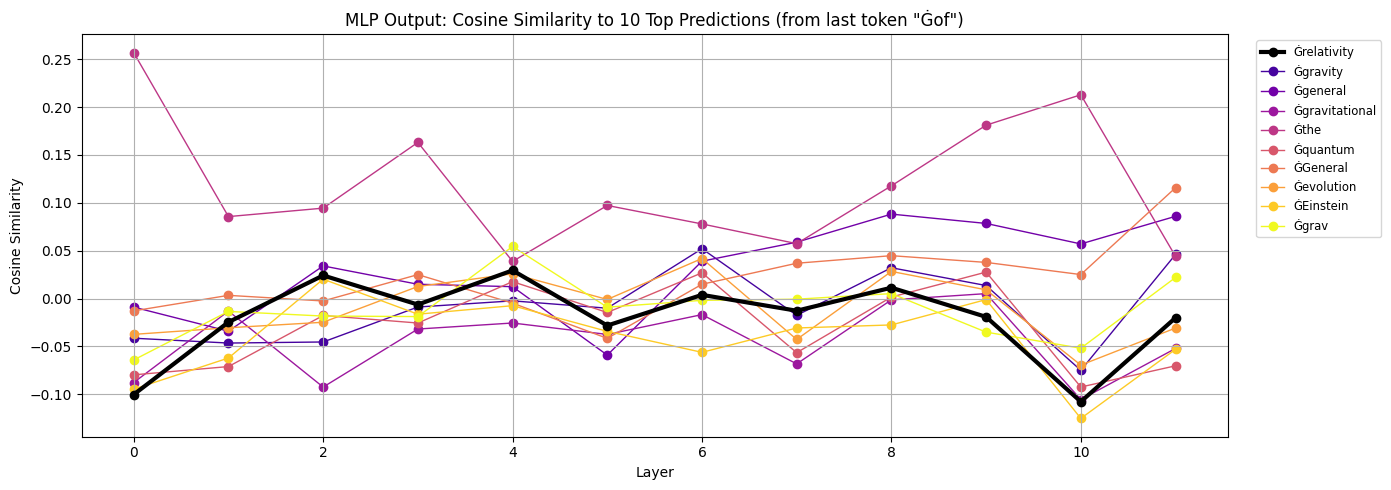

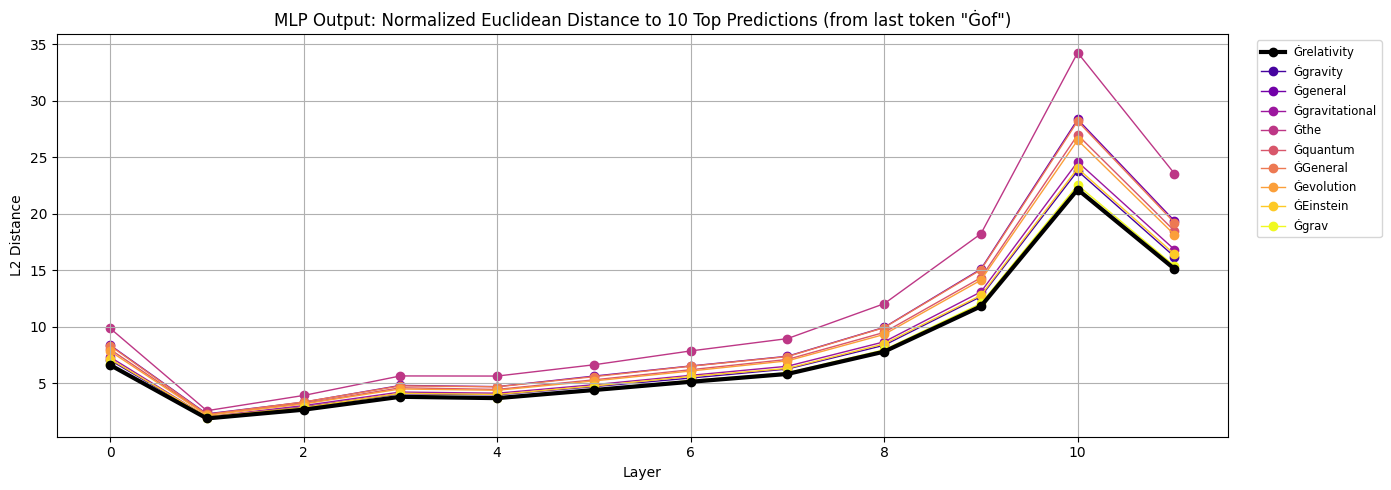

C:\Users\angel\AppData\Local\Temp\ipykernel_25076\3314977747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(top_tokens))


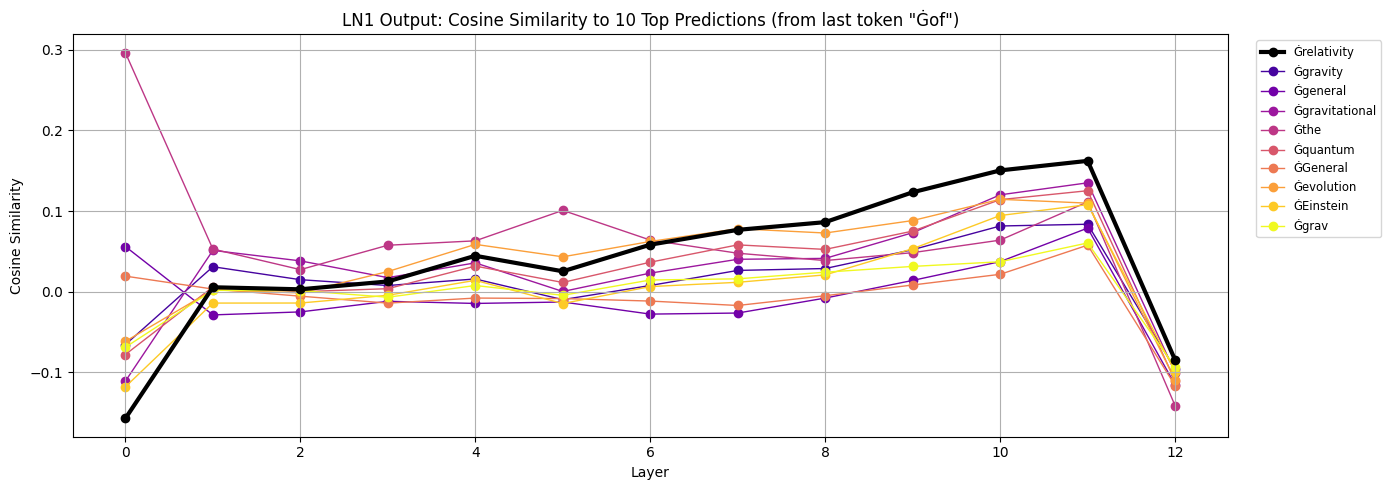

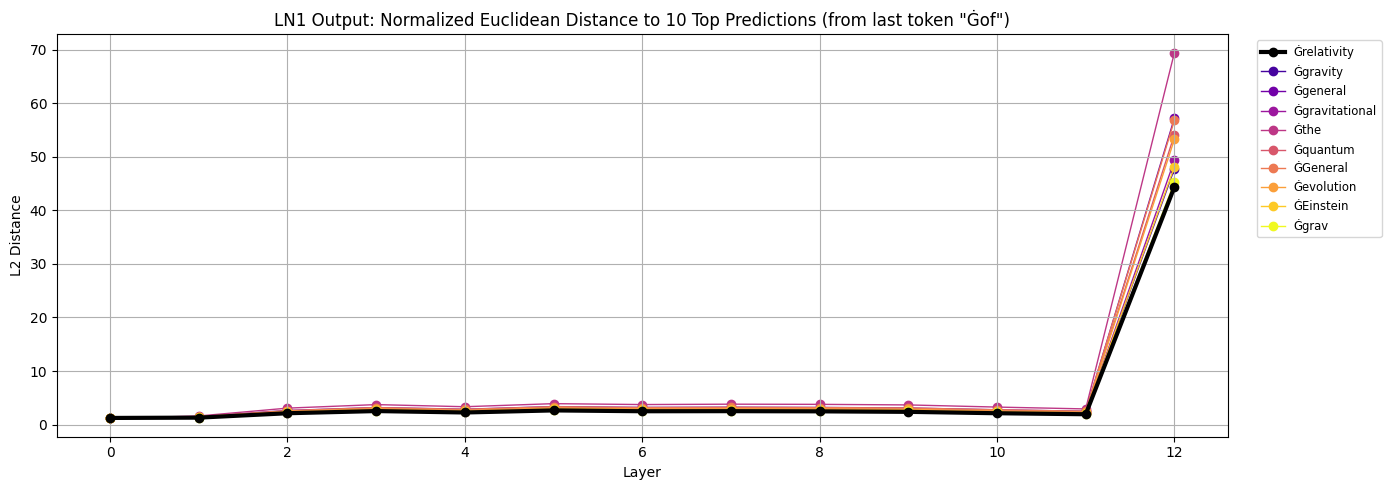

In [53]:
def compare_multiple_targets(outputs_list, target_embeds, token_position, token_label, top_tokens, label):
    n_layers = len(outputs_list)
    cos_sims_all = []
    eucl_dists_all = []
    norm_eucl_dists_all = []

    for idx, target_embed in enumerate(target_embeds):
        cos_sims = []
        eucl_dists = []
        norm_eucl_dists = []
        for layer in range(n_layers):
            vec = outputs_list[layer][0, token_position].cpu().numpy()
            cos_sims.append(cosine_similarity([vec], [target_embed])[0][0])
            eucl_dists.append(np.linalg.norm(vec - target_embed))
            norm_diff = np.linalg.norm(vec - target_embed)
            norm_base = np.linalg.norm(target_embed)
            normalized_dist = norm_diff / (norm_base + 1e-8)  # Avoid division by zero
            norm_eucl_dists.append(normalized_dist)

        cos_sims_all.append(cos_sims)
        eucl_dists_all.append(eucl_dists)
        norm_eucl_dists_all.append(norm_eucl_dists)
        

    # Prepare colors from plasma colormap
    cmap = cm.get_cmap("plasma", len(top_tokens))
    colors = [cmap(i) for i in range(len(top_tokens))]

    # Plot Cosine Similarity
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(cos_sims_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Cosine Similarity to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


    # Plot normalized Euclidean Distance
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(norm_eucl_dists_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Normalized Euclidean Distance to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("L2 Distance")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return cos_sims_all, eucl_dists_all, norm_eucl_dists

token_position = -1
token_label = tokens[token_position]

# Run similarity comparison
attn_cos_all, attn_dist_all, _ = compare_multiple_targets(
    attention_outputs, top_embeddings, token_position, token_label, top_tokens, "Attention Output"
)

mlp_cos_all, mlp_dist_all, _ = compare_multiple_targets(
    mlp_outputs, top_embeddings, token_position, token_label, top_tokens, "MLP Output"
)

ln_cos_all, ln_dist_all, _ = compare_multiple_targets(
    ln1_outputs, top_embeddings, token_position, token_label, top_tokens, "LN1 Output"
)


### VOLUME
To compute the volume of a polytope formed by token representations before and after the Feed-Forward Neural Network (FFNN) in a transformer model, you can approximate it using the square root of the determinant of the Gram matrix (a generalization of volume for vector sets in high dimensions).


✅ What You Need:
Hidden states before and after FFNN.


Construct the matrix 𝑉V using token vectors as rows.

Compute 
det(𝑉𝑉^𝑇)  — you might need regularization.

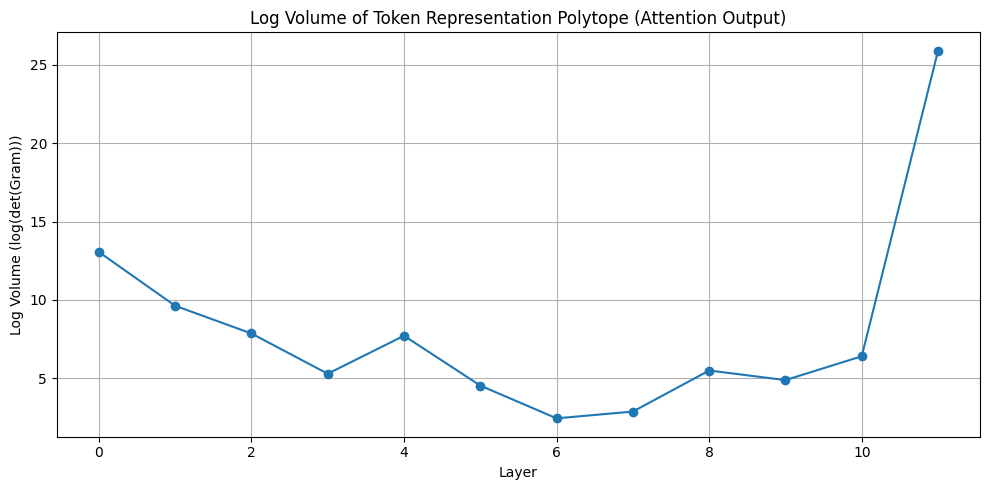

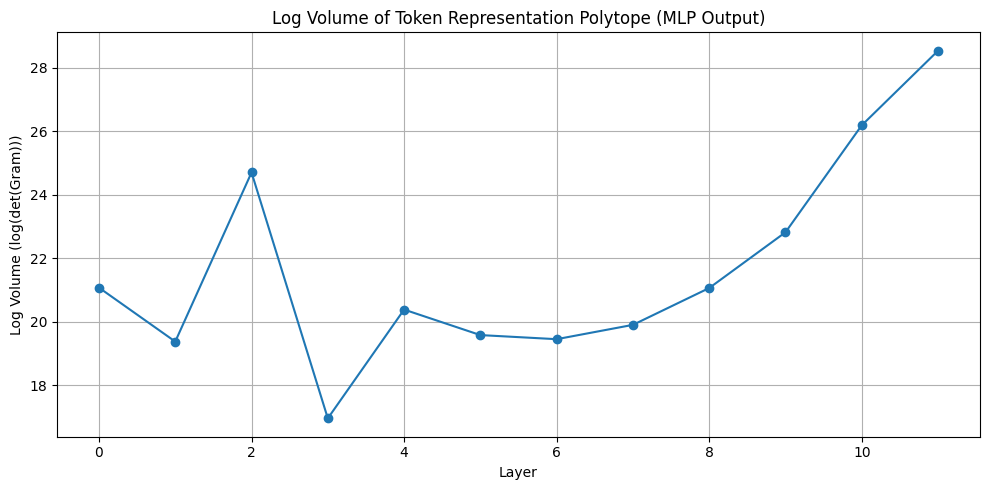

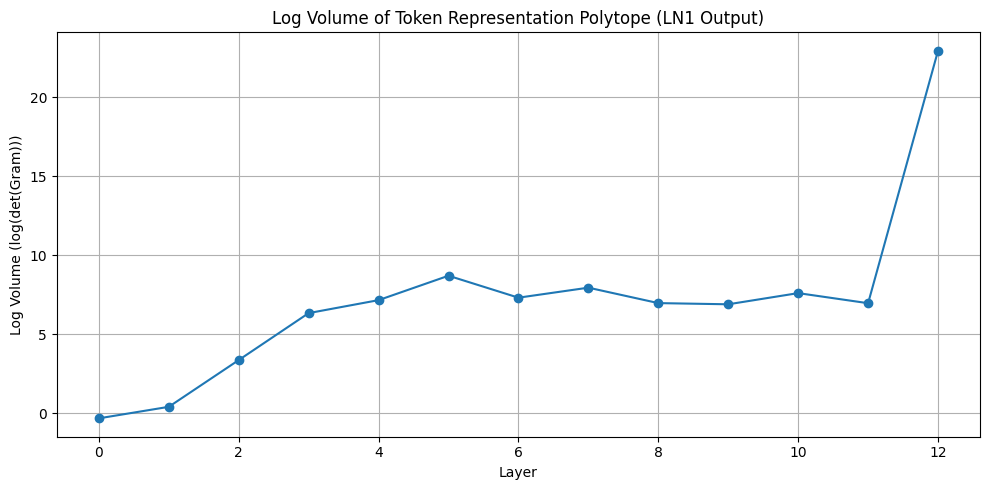

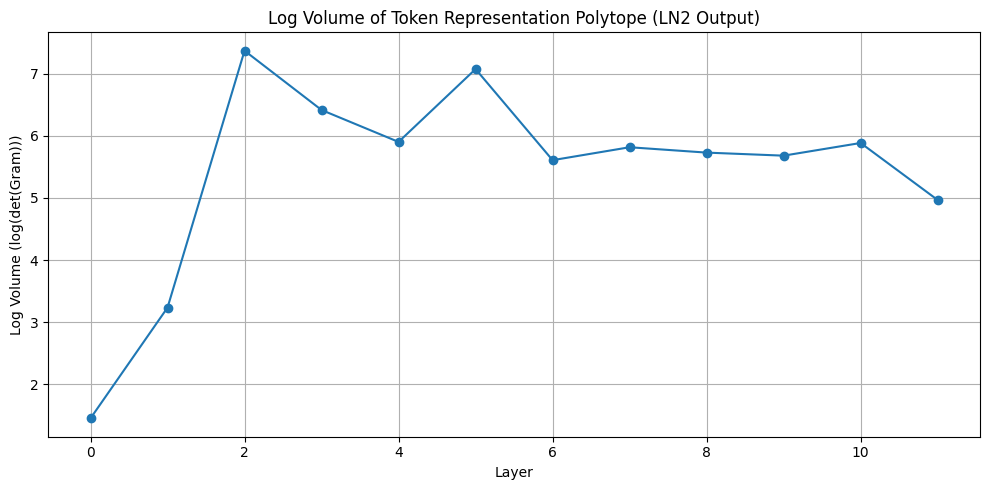

In [28]:
def compute_log_volume(outputs_list, label, epsilon=1e-6, plot_v=False):
    log_volumes = []

    for layer_idx in range(len(outputs_list)):
        layer_vecs = outputs_list[layer_idx][0]  # shape: [seq_len, hidden_dim]

        # Center the vectors
        centered = layer_vecs - layer_vecs.mean(dim=0)
        V = centered.detach().cpu().numpy()

        # Gram matrix
        G = V @ V.T  # shape: [seq_len, seq_len]

        # Stable log-determinant of Gram
        try:
            log_det = 0.5* np.linalg.slogdet(G + epsilon * np.eye(G.shape[0]))[1]
        except np.linalg.LinAlgError:
            log_det = float('-inf')

        log_volumes.append(log_det)

    # Plot
    if plot_v:
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(outputs_list)), log_volumes, marker='o')
        plt.title(f"Log Volume of Token Representation Polytope ({label})")
        plt.xlabel("Layer")
        plt.ylabel("Log Volume (log(det(Gram)))")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return log_volumes


attn_log_vols = compute_log_volume(attention_outputs, "Attention Output", plot_v=True)
mlp_log_vols = compute_log_volume(mlp_outputs, "MLP Output", plot_v=True)
ln1_log_vols = compute_log_volume(ln1_outputs, "LN1 Output", plot_v=True)
ln2_log_vols = compute_log_volume(ln2_outputs, "LN2 Output", plot_v=True)


1 13 12 12 12


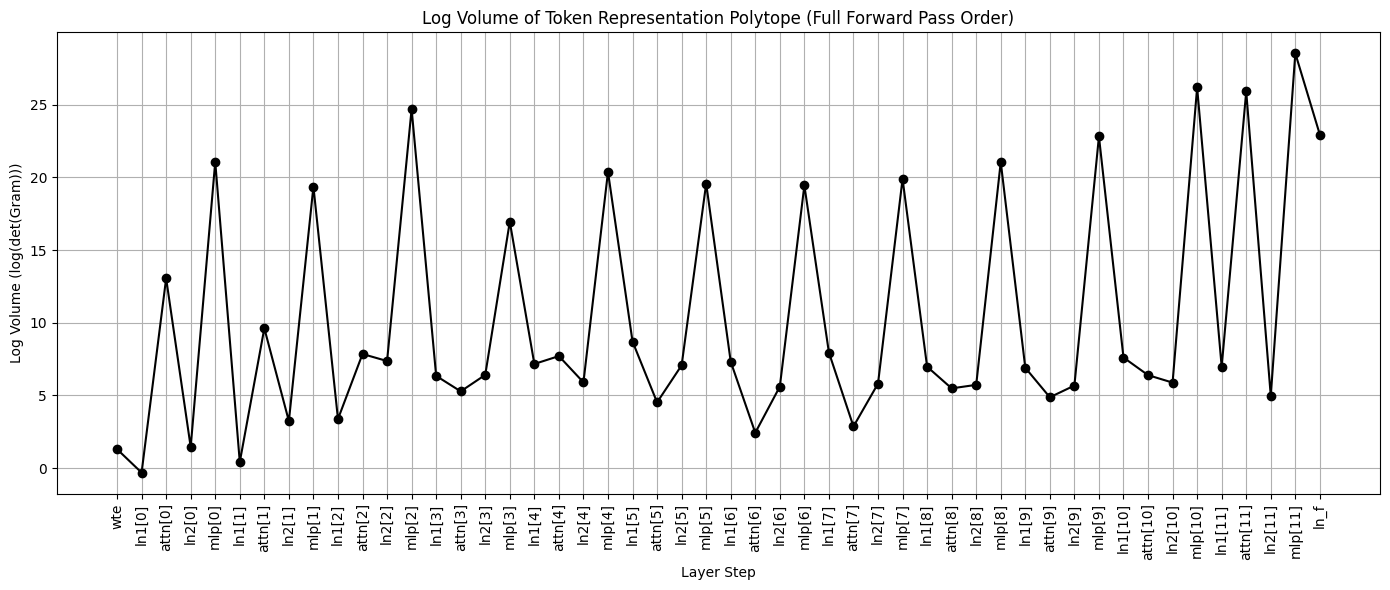

In [29]:
# Step 1: Compute all log volumes
print(len(embedding_outputs), len(ln1_outputs), len(attention_outputs), len(ln2_outputs), len(mlp_outputs))

emb_log_vols = compute_log_volume(embedding_outputs, '') # len = 2
ln1_log_vols = compute_log_volume(ln1_outputs, '')       # len = 13
attn_log_vols = compute_log_volume(attention_outputs, '')  # len = 12
ln2_log_vols = compute_log_volume(ln2_outputs, '')       # len = 12
mlp_log_vols = compute_log_volume(mlp_outputs, '')       # len = 12

# Step 2: Interleave them into a single list
all_log_vols = []
layer_labels = []
all_log_vols.append(emb_log_vols[0])
layer_labels.append('wte')
#all_log_vols.append(emb_log_vols[1])
#layer_labels.append('wpe')

for i in range(12):  # 12 layers
    all_log_vols.append(ln1_log_vols[i])
    layer_labels.append(f"ln1[{i}]")

    all_log_vols.append(attn_log_vols[i])
    layer_labels.append(f"attn[{i}]")

    all_log_vols.append(ln2_log_vols[i])
    layer_labels.append(f"ln2[{i}]")

    all_log_vols.append(mlp_log_vols[i])
    layer_labels.append(f"mlp[{i}]")

# Add final ln1[12] (ln_f)
all_log_vols.append(ln1_log_vols[12])
layer_labels.append("ln_f")

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.plot(range(len(all_log_vols)), all_log_vols, marker='o', color='black')
plt.xticks(ticks=range(len(all_log_vols)), labels=layer_labels, rotation=90)
plt.title("Log Volume of Token Representation Polytope (Full Forward Pass Order)")
plt.xlabel("Layer Step")
plt.ylabel("Log Volume (log(det(Gram)))")
plt.grid(True)
plt.tight_layout()
plt.show()


### PCA

max possible rank is $D^*=min(D, N-1)$

try the lambda vs index plot (see if there is a spectral gap -> if yes we're good, if no check the null hypothesis Marchenko Pastur Distribution)

choose d for each layer

then try to construct the cross gram matrix, svd -> get the "eigen angles" $\sigma_j$ and reconstruct the principal angle $\Theta = \sum_j cos^{-1} \sigma_j$


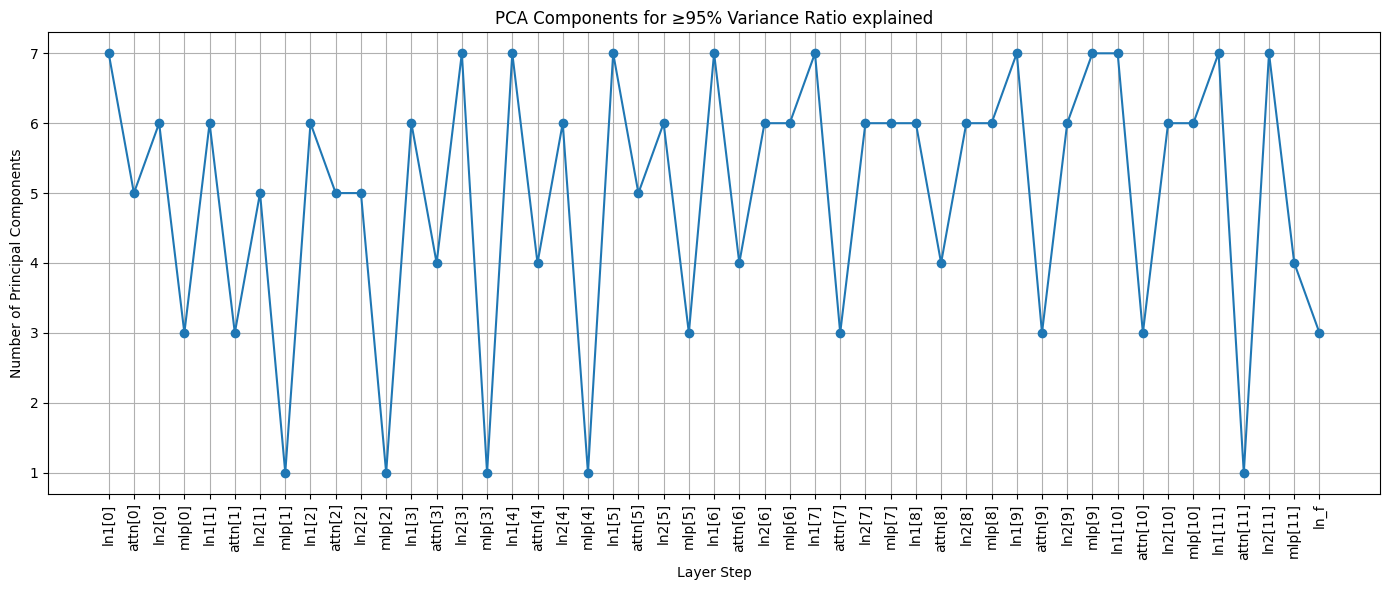

In [60]:
def compute_pca_components(outputs_list, cumulative_threshold=0.9):
    component_counts = []

    for out in outputs_list:
        vecs = out[0].cpu().numpy()  # shape: [seq_len, hidden_dim]
        pca = PCA()
        pca.fit(vecs)
        explained = pca.explained_variance_ratio_
        cumulative = np.cumsum(explained)
        num_components = np.searchsorted(cumulative, cumulative_threshold) + 1
        component_counts.append(num_components)

    return component_counts

#pca_emb = compute_pca_components(embedding_outputs)
pca_ln1 = compute_pca_components(ln1_outputs)
pca_attn = compute_pca_components(attention_outputs)
pca_ln2 = compute_pca_components(ln2_outputs)
pca_mlp = compute_pca_components(mlp_outputs)

interleaved_counts = []
labels = []

#interleaved_counts.append(pca_emb)
#labels.append(f"wte")

for i in range(12):  # For 12 layers
    interleaved_counts.append(pca_ln1[i])
    labels.append(f"ln1[{i}]")

    interleaved_counts.append(pca_attn[i])
    labels.append(f"attn[{i}]")

    interleaved_counts.append(pca_ln2[i])
    labels.append(f"ln2[{i}]")

    interleaved_counts.append(pca_mlp[i])
    labels.append(f"mlp[{i}]")

# Add final ln_f
interleaved_counts.append(pca_ln1[12])  # assuming you added ln_f to ln1_outputs
labels.append("ln_f")

plt.figure(figsize=(14, 6))
plt.plot(interleaved_counts, marker='o', label='≥90% variance')

plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.title("PCA Components for ≥95% Variance Ratio explained")
plt.xlabel("Layer Step")
plt.ylabel("Number of Principal Components")
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.show()


In [39]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D projection

def plot_pca_trajectories(outputs_list, label, tokens, top_embeddings, top_tokens):
    n_layers = len(outputs_list)

    # 1. Get the last token's vector across layers
    last_token_vecs = np.stack([outputs_list[i][0, -1].cpu().numpy() for i in range(n_layers)])  # [n_layers, hidden_dim]

    # 2. Stack with top token embeddings for joint PCA
    all_vecs = np.vstack([last_token_vecs] + list(top_embeddings))  # shape: [n_layers + 10, hidden_dim]

    # 3. PCA to 2D
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(all_vecs)

    reduced_last = reduced[:n_layers]       # [n_layers, 2]
    reduced_top = reduced[n_layers:]        # [10, 2]

    # 4. Plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot trajectory of last token across layers
    x_last, y_last, z_last = reduced_last.T
    ax.plot(x_last, y_last, z_last, marker='o', color='red', label=f'Last Token ("{tokens[-1]}")')
    for i, (x, y, z) in enumerate(reduced_last):
        ax.text(x + 0.01, y + 0.01, z + 0.01, f'L{i}', fontsize=8, color='red')

    # Plot top token embeddings
    for i, (x, y, z) in enumerate(reduced_top):
        color = 'black' if i == 0 else plt.cm.plasma(i / len(top_tokens))
        ax.scatter(x, y, z, color=color, s=60, marker='x', label=top_tokens[i].strip() if i == 0 else None)
        ax.text(x + 0.01, y + 0.01, z + 0.01, top_tokens[i].strip(), fontsize=8, color=color)

    ax.set_title(f"3D PCA: Last Token Trajectory + Top Token Embeddings ({label})")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

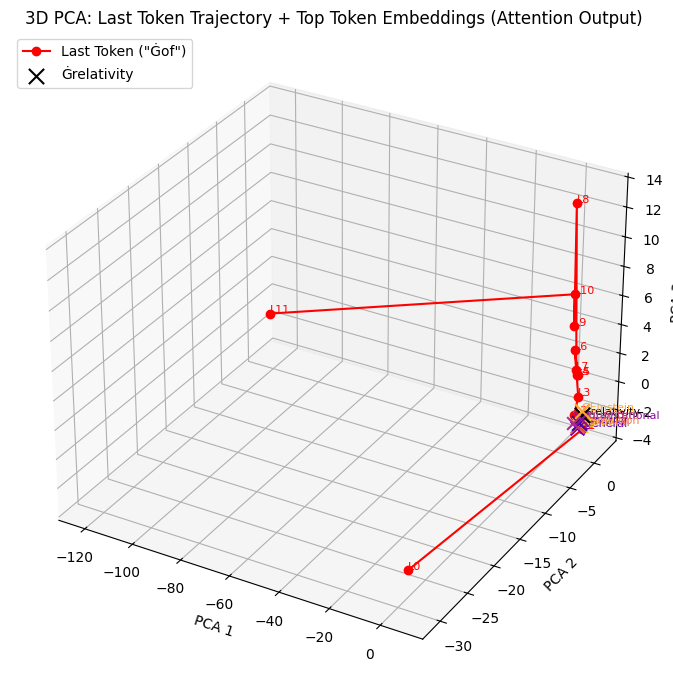

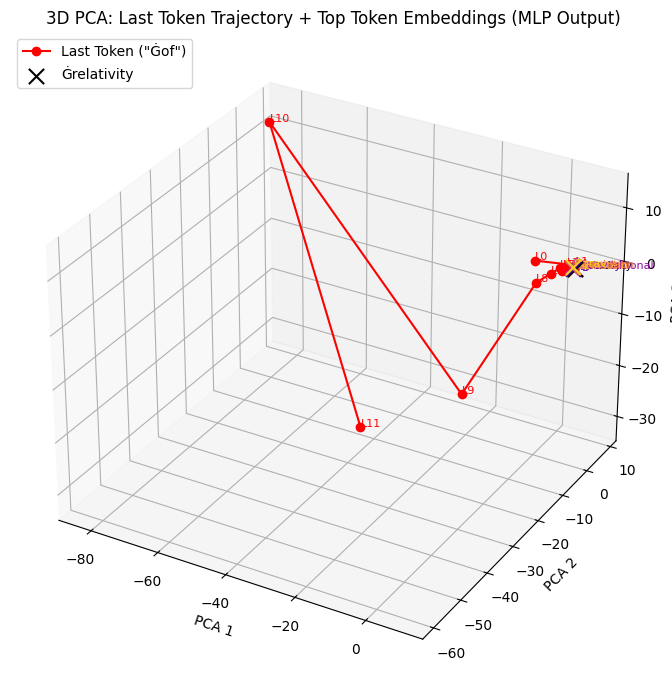

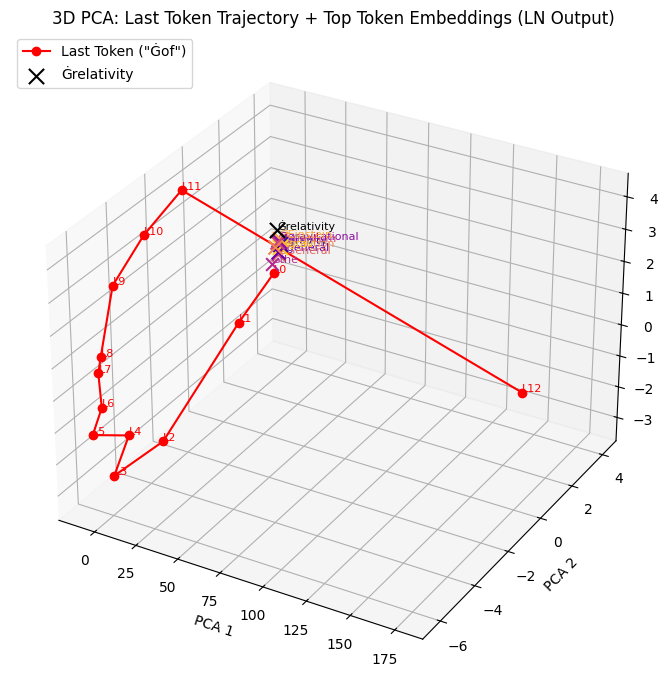

In [58]:
plot_pca_trajectories(attention_outputs, "Attention Output", tokens, top_embeddings, top_tokens)
plot_pca_trajectories(mlp_outputs, "MLP Output", tokens, top_embeddings, top_tokens)
plot_pca_trajectories(ln1_outputs, "LN Output", tokens, top_embeddings, top_tokens)


In [41]:
from mpl_toolkits.mplot3d import Axes3D  # 3D projection
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_all_token_trajectories_3d(outputs_list, label, relativity_embedding, tokens=None):
    n_layers = len(outputs_list)
    seq_len = outputs_list[0].shape[1]

    # 1. Stack all token vectors from all layers: [n_layers * seq_len, hidden_dim]
    all_vecs = np.vstack([outputs_list[i][0].cpu().numpy() for i in range(n_layers)])  # [n_layers * seq_len, hidden_dim]

    # 2. Combine with "relativity" embedding for PCA
    all_with_rel = np.vstack([all_vecs, relativity_embedding])  # shape: [n_layers * seq_len + 1, hidden_dim]

    # 3. PCA to 3D
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(all_with_rel)

    reduced_vecs = reduced[:-1]  # [n_layers * seq_len, 3]
    reduced_rel = reduced[-1]    # [3]

    # 4. Reshape back to [n_layers, seq_len, 3]
    reduced_reshaped = reduced_vecs.reshape(n_layers, seq_len, 3)

    # 5. Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for tok_idx in range(seq_len):
        x, y, z = zip(*[reduced_reshaped[layer][tok_idx] for layer in range(n_layers)])
        ax.plot(x, y, z, marker='o', alpha=0.6)
        if tokens:
            ax.text(x[-1], y[-1], z[-1], tokens[tok_idx], fontsize=7)

    # Plot "relativity" embedding
    ax.scatter(*reduced_rel, color='black', s=100, marker='X', label='"Ġrelativity" embedding')
    ax.text(*reduced_rel, '"relativity"', fontsize=10, color='black')

    ax.set_title(f"3D PCA: Token Trajectories Across Layers ({label})")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    ax.legend()
    plt.tight_layout()
    plt.show()


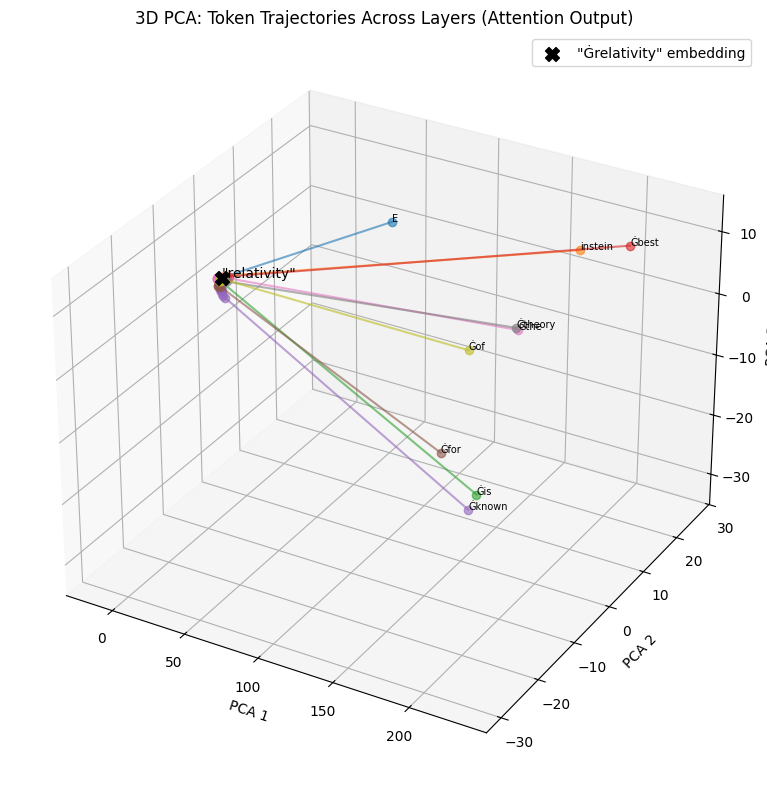

In [43]:
plot_all_token_trajectories_3d(
    outputs_list=ln1_outputs,
    label="Attention Output",
    relativity_embedding=top_embeddings[0],  # assuming index 0 is 'Ġrelativity'
    tokens=tokens  # optional, shows token labels at final layer
)
